# BEATS WB commissioning - flat field at full beam aperture

### Filters:
- C 5.0 mm
- Si 5.0 mm
______________________________________________________

Author:         Gianluca Iori (gianthk.iori@gmail.com)

Created on:   07/02/2024

Last update:  28/11/2023
______________________________________________________


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from scipy import constants
import dxchange
# from pandas_ods_reader import read_ods
# import h5py

In [2]:
from DMM.commissioning.tomoalign_simple import fit_profile

In [3]:
# plt.style.use('seaborn-v0_8-talk')
plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('tableau-colorblind10')
# plt.style.use('default')

In [4]:
%matplotlib inline
font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

In [5]:
matplotlib.rcParams['figure.dpi'] = 200

In [18]:
# data_dir = 'smb://10.1.14.100/pco-flir-ws/FLIR_Data/'
work_dir = '/home/beatsbs/PycharmProjects/BEATS_raytracing/beam_profiles/'

### 1. Read SSCAN data

In [19]:
h5file = work_dir+'flat_field_5mmSi_full__003.h5'

In [20]:
print(h5file)

/home/beatsbs/PycharmProjects/BEATS_raytracing/beam_profiles/flat_field_5mmSi_full__003.h5


In [25]:
data = dxchange.read_hdf5(h5file, "/entry/data/data")
print(data.shape)

(800, 1800, 3208)


### 2. Average each 40 images

In [84]:
n_avg = 40

data_mean = np.zeros((20, 1800, 3208), dtype='uint16')
for x_block in range(0,20):
    # print(n_avg*x_block)
    # print(n_avg*x_block+n_avg-1)
    data_mean[x_block, :, :] = np.mean(data[n_avg*x_block:n_avg*x_block+n_avg, :, :], axis=0)
    # data_mean[x_block, :, :] = np.sum(data[n_avg*x_block:n_avg*x_block+n_avg-1, :, :])

Show data before and after averaging)

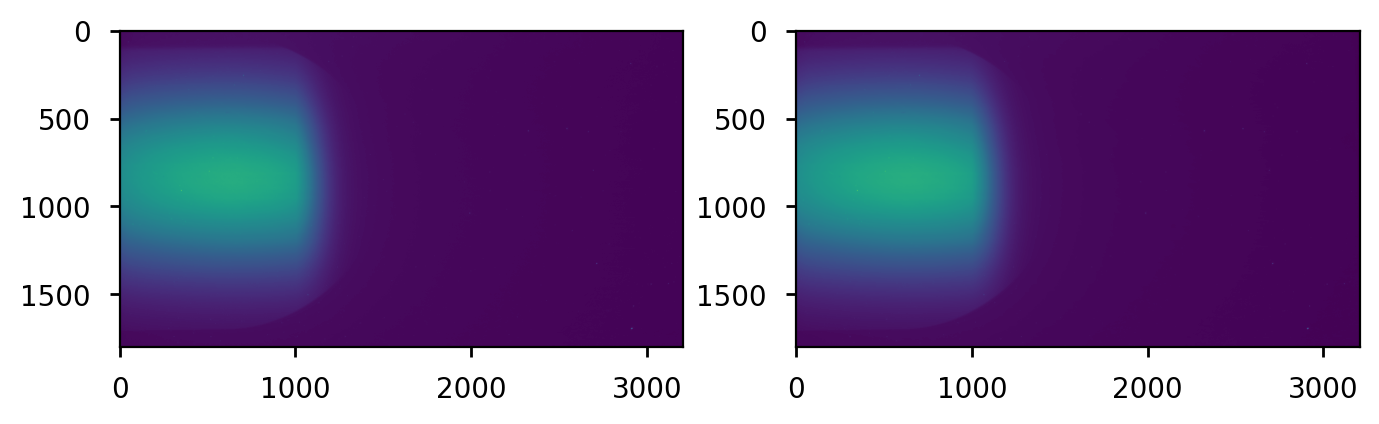

In [86]:
step = 19
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[step*n_avg, :, :])
ax2.imshow(data_mean[step, :, :])

### 3. Fit Gaussian through the center

Average again the central part of the profile

In [87]:
I_mean = np.mean(data_mean[10, :, 1000:2000], axis=1)

In [200]:
pixel_size = 4.5/0.48 # [um]
Y_array = np.flip(np.arange(0, I_mean.size)*pixel_size)
Y_array = Y_array - np.mean(Y_array)

print(pixel_size)

9.375


Text(0, 0.5, 'Average intensity [a.u.]')

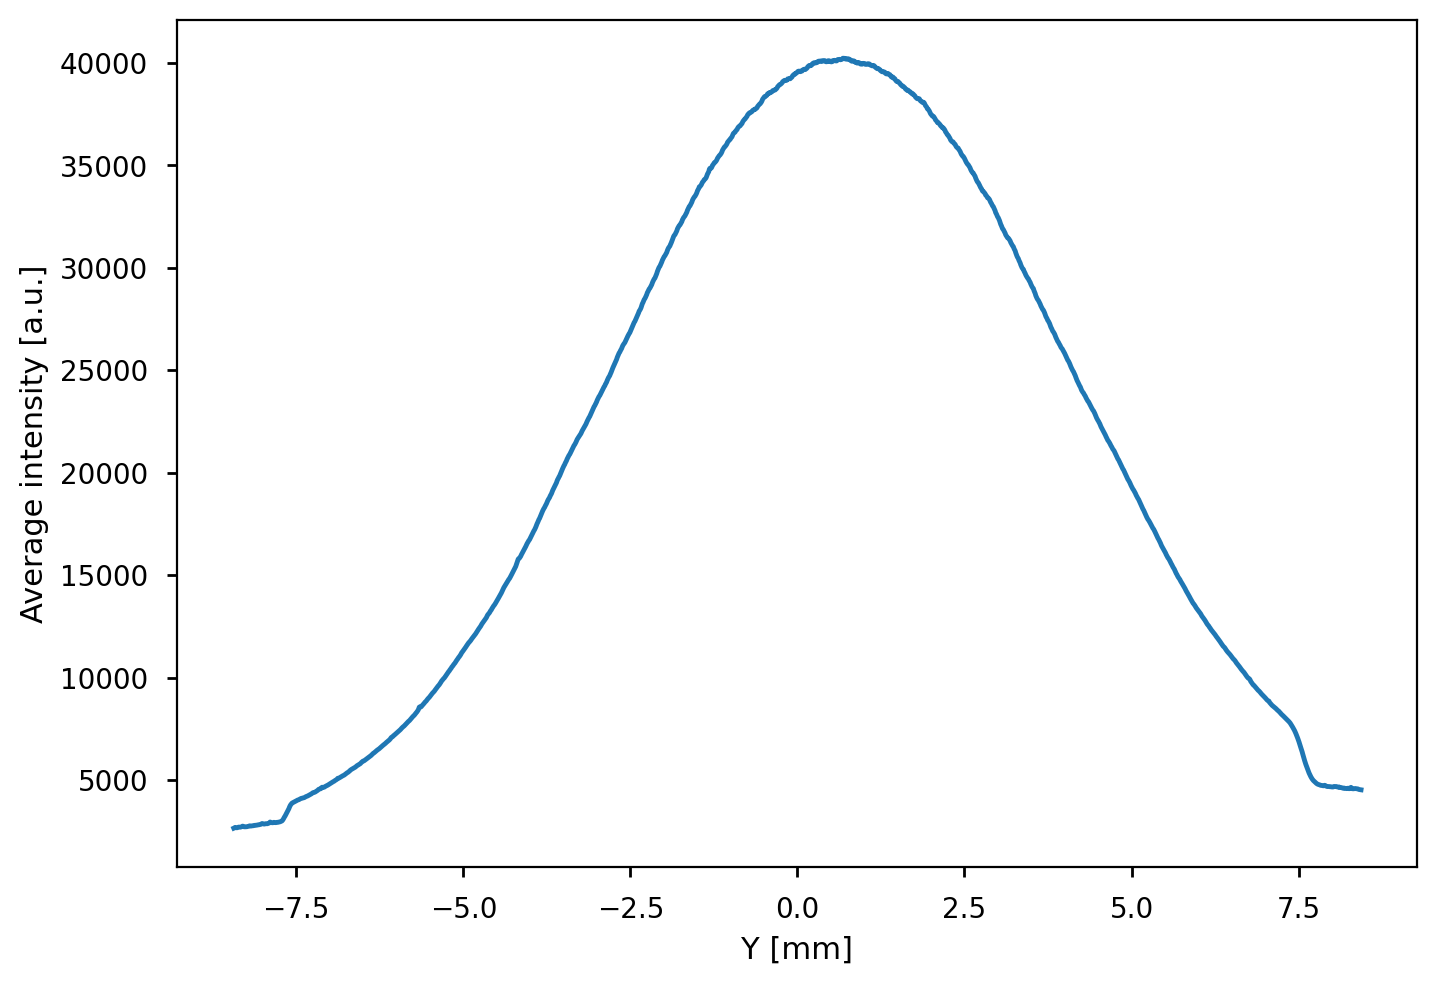

In [201]:
plt.plot(Y_array*1e-3, I_mean)
plt.xlabel("Y [mm]")
plt.ylabel("Average intensity [a.u.]")

### 1.4 Perform curve fit

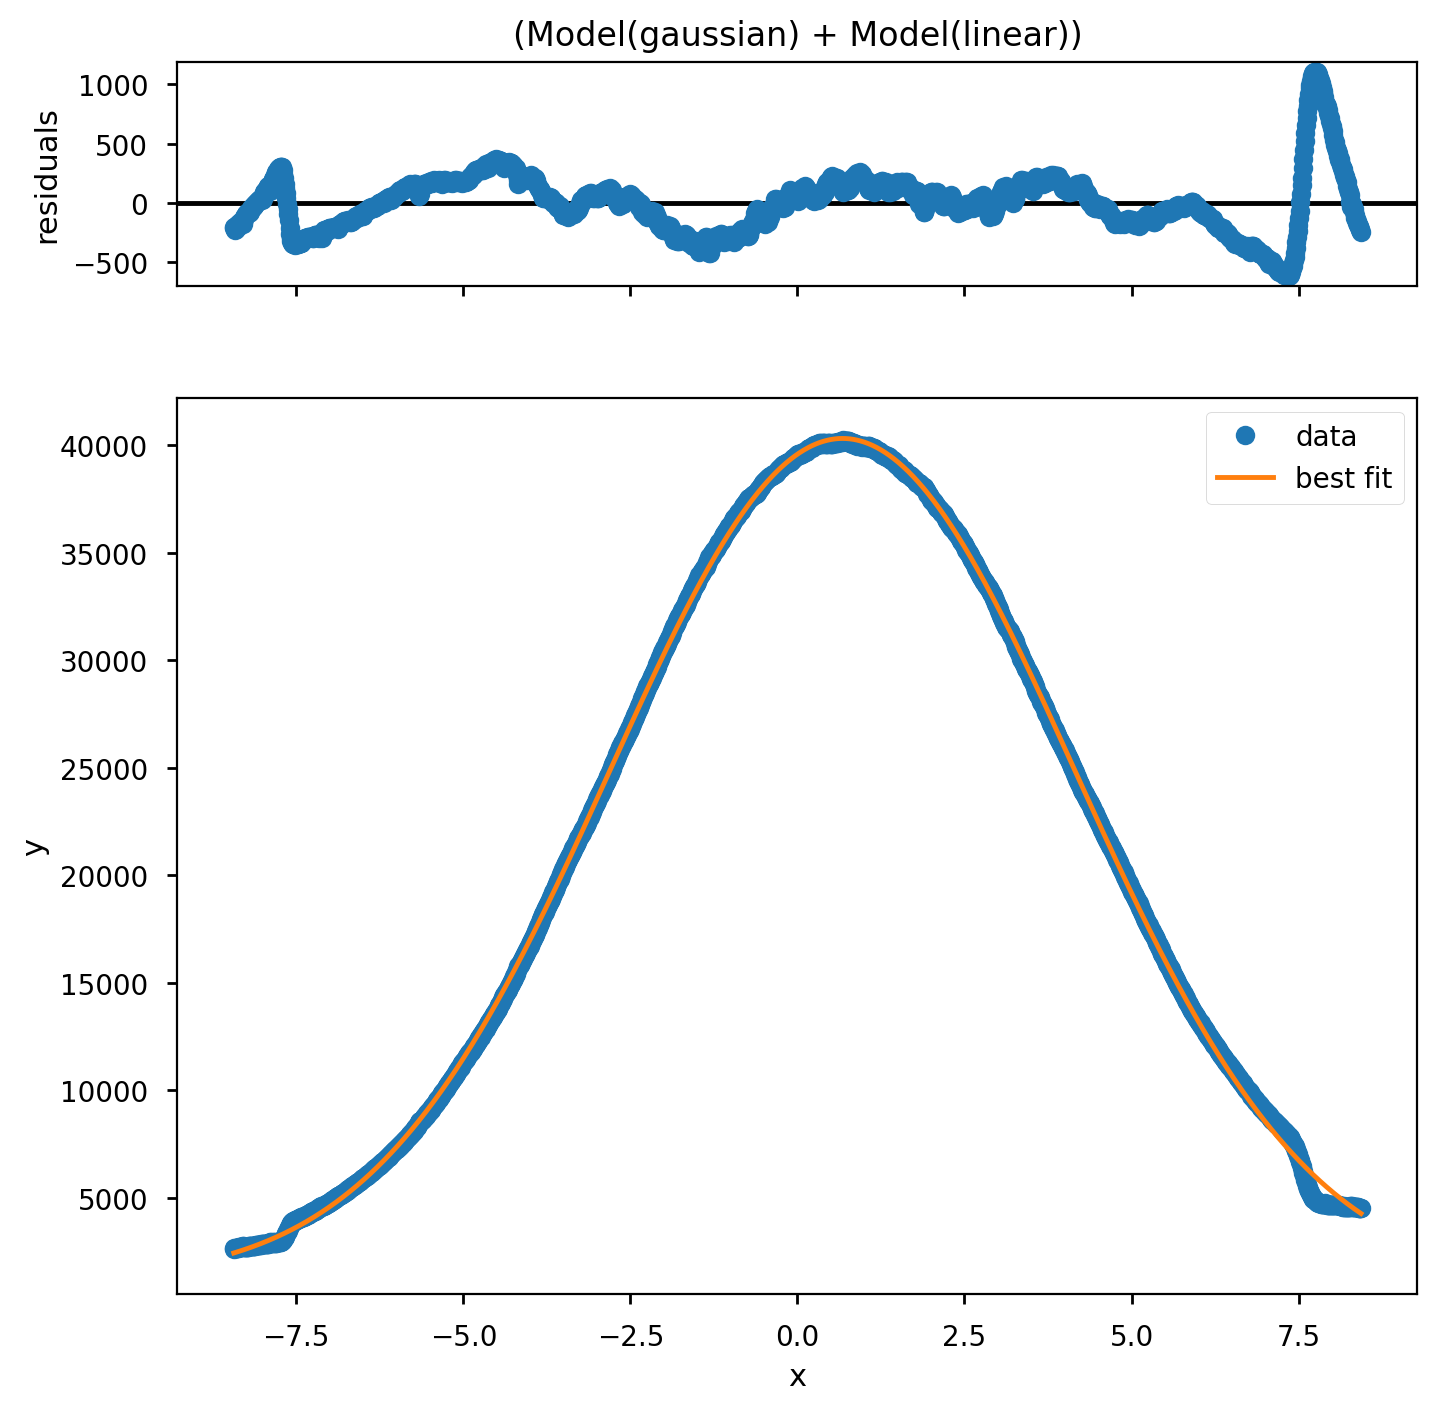

In [202]:
fit_result = fit_profile(Y_array*1e-3, I_mean, profile='gaussian', background='linear', plot=True) # , width=1400

In [206]:
fit_result

## 2. positioner data from SSCAN

In [110]:
Det_X = np.array([87.750275, 91.707425, 95.665325, 99.623025, 103.580925, 107.538925, 111.496575, 115.454625, 119.412575, 123.370525, 127.328475, 131.286175, 135.243925, 139.202025, 143.159825, 147.117575, 151.075925, 155.033475, 158.991475, 162.949525])

## 3. Save processed images

In [126]:
margin = 0

In [108]:
for image in range(0,data_mean.shape[0]):
    image_name = work_dir+'processed_images/flat_field_full_Det_Y'+str(Det_X[image])
    dxchange.write_tiff(data_mean[image, :, :], image_name)

Saved a version cropped in the center

In [111]:
Det_X_delta = Det_X[1]-Det_X[0]
print(Det_Y_delta)

3.9571499999999986


In [112]:
FOV_X = pixel_size*data_mean.shape[2]*1e-3 # [mm]
print(FOV_X)

30.075


In [116]:
Det_X_delta_pixels = Det_X_delta/(pixel_size*1e-3) # [pixels]
print(Det_X_delta_pixels)

422.0959999999999


In [124]:
int(np.floor(data_mean.shape[2]/2 - Det_X_delta_pixels/2))-margin

1382

In [128]:
for image in range(0,data_mean.shape[0]):
    image_name = work_dir+'processed_images/cropped/flat_field_full_Det_Y'+str(Det_X[image])
    dxchange.write_tiff(data_mean[image, :, int(np.floor(data_mean.shape[2]/2 - Det_X_delta_pixels/2))-margin : int(np.floor(data_mean.shape[2]/2 + Det_X_delta_pixels/2))+margin], image_name)

## 4. Make collage

In [146]:
collage = np.zeros((data_mean.shape[1], 1))
image = 0
collage = np.append(collage, data_mean[image, :, 500:int(np.floor(data_mean.shape[2]/2 + Det_X_delta_pixels/2))+margin], axis=1)

for image in range(1,data_mean.shape[0]):
    collage = np.append(collage, data_mean[image, :, int(np.floor(data_mean.shape[2]/2 - Det_X_delta_pixels/2))-margin : int(np.floor(data_mean.shape[2]/2 + Det_X_delta_pixels/2))+margin], axis=1)

In [157]:
print(collage.shape)

(1800, 9353)


In [187]:
Y_array.shape

(1800,)

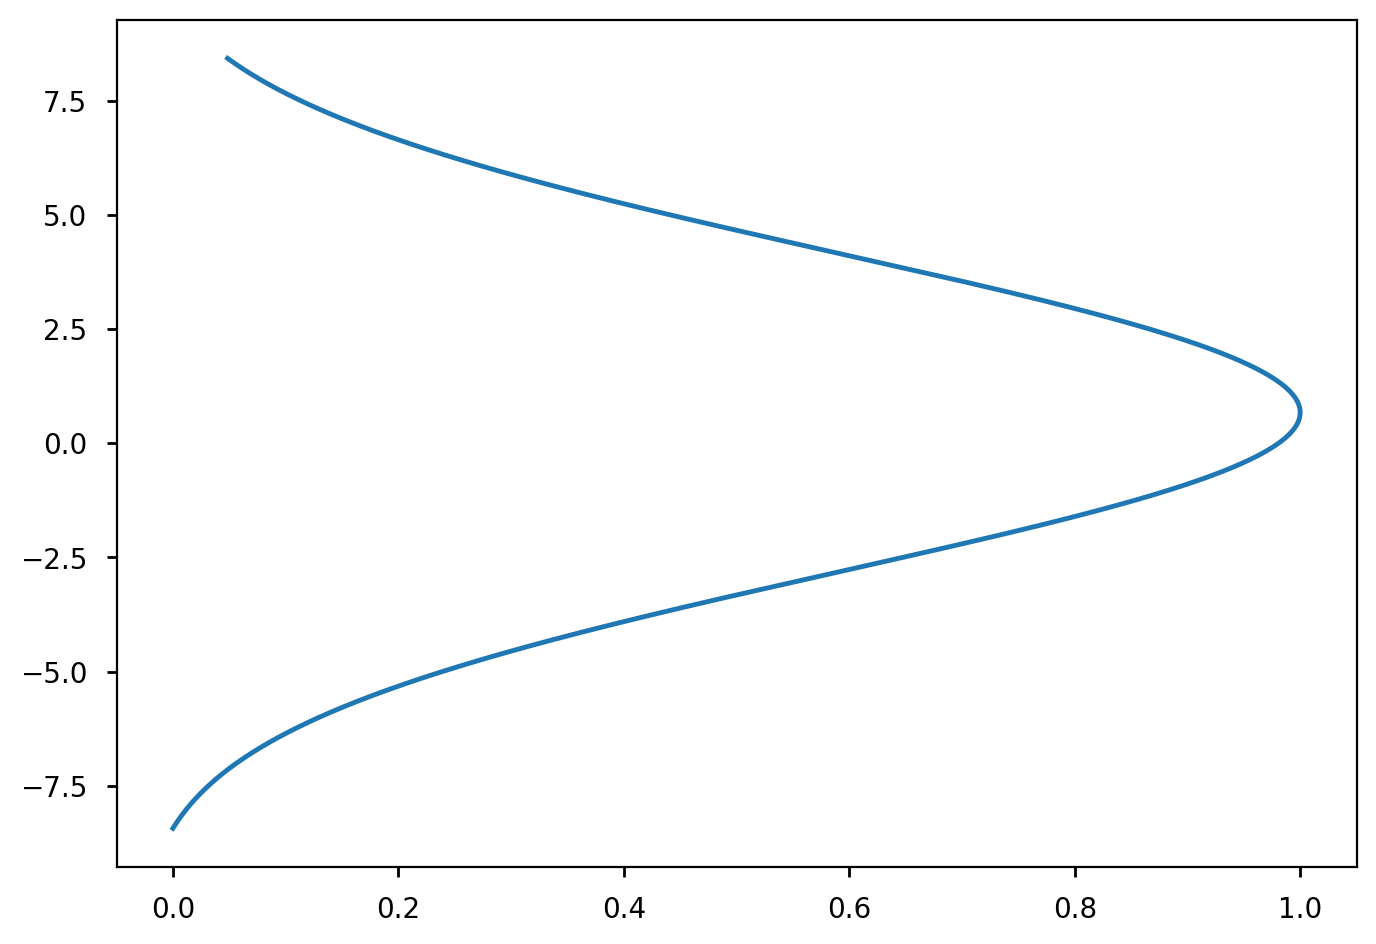

In [203]:
plt.plot((fit_result.best_fit-np.min(fit_result.best_fit))/np.max(fit_result.best_fit-np.min(fit_result.best_fit)), Y_array*1e-3)

In [210]:
fit_result.params['center'].value

0.6784853006585427

In [251]:
# mask some 'bad' data, in your case you would have: data == 0
th = 0.15
collage_n = collage/np.max(collage)
collage_n = np.ma.masked_where(collage_n < th, collage_n)

# cmap = plt.cm.OrRd

# for mpl 3.3 and higher use
cmap = matplotlib.colormaps["OrRd"] # OrRd

cmap.set_bad(color='black')

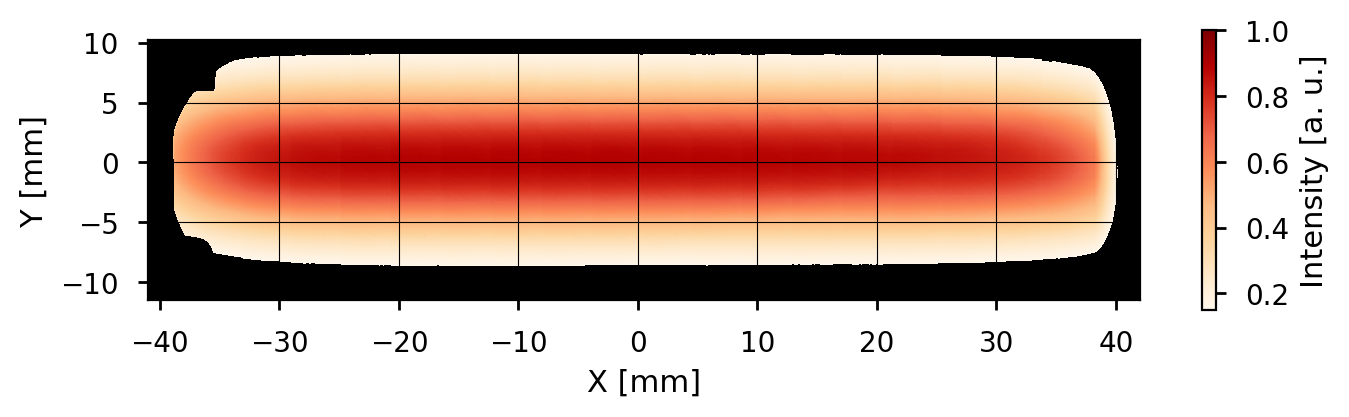

In [259]:
f, ax = plt.subplots()
x_start = - 1e-3 * pixel_size * collage.shape[1] / 2
x_end = 1e-3 * pixel_size * collage.shape[1] / 2
y_start = - 1e-3 * pixel_size * collage.shape[0] / 2 - fit_result.params['center'].value
y_end = 1e-3 * pixel_size * collage.shape[0] / 2 - fit_result.params['center'].value
im = ax.imshow(collage_n, extent=[-2.5 + x_start, x_end + 2.5, y_start - 2.5, y_end + 2.5], cmap=cmap, norm = matplotlib.colors.Normalize(vmin=th, vmax=1)) # matplotlib.cm.RdGy_r 'plasma', matplotlib.cm.RdYlBu, matplotlib.cm.bwr
plt.xticks(np.arange(-50, 50, 10))
plt.yticks(np.arange(-10, 15, 5))
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
# profile = ax.plot((10*fit_result.best_fit-np.min(fit_result.best_fit))/np.max(fit_result.best_fit-np.min(fit_result.best_fit)), Y_array*1e-3 - fit_result.params['center'].value, color='b', linestyle='--', linewidth=1.5)
plt.grid(True, which="both", color='k', linewidth=0.4)
CB = fig.colorbar(im, shrink=0.33)
CB.set_label('Intensity [a. u.]')
ax.set(xlim=(-41, 42), ylim=(-11.5, 10.2))
plt.show()
# f.savefig("BEATS_white_beam_full_aperture_C5mm_Si5mm.tiff", bbox_inches='tight', dpi=600)
f.savefig("BEATS_white_beam_full_aperture_C5mm_Si5mm.jpg", bbox_inches='tight', dpi=600)

Save collage

In [151]:
dxchange.write_tiff(collage, work_dir+'processed_images/collage')